In [15]:
import os
import sys

import pandas as pd
import numpy as np
import random
import itertools

from matplotlib import pyplot as plt

from tqdm import tqdm

from pandarallel import pandarallel

import pymorphy2
import nltk
import pickle
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

import gensim
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.phrases import Phrases, Phraser

import time


SEED = 1
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True
init_random_seed(SEED)
    
pd.set_option('display.max_colwidth', 255)
tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=8, use_memory_fs=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [16]:
abbr = pd.read_csv("../data/abbr.csv")
lenta_train = pd.read_csv("../data/lenta_train.csv")
lenta_test = pd.read_csv("../data/lenta_test.csv")

In [4]:
from pytorch_transformers import BertTokenizer, BertConfig

MODEL_NAME = 'bert-base-uncased'
MAX_MODEL_INPUT_SIZE = 512

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)

In [5]:
def tokenize_text(text, 
                  tokenizer=tokenizer, 
                  max_len=MAX_MODEL_INPUT_SIZE, 
                  add_cls_sep: bool = False):
    tokenized_text = tokenizer.tokenize(text)
    tokenized_text = [tokenizer.convert_tokens_to_ids(token) for token in tokenized_text]
    
    if add_cls_sep:
        cls_token = tokenizer.convert_tokens_to_ids("[CLS]")
        sep_token = tokenizer.convert_tokens_to_ids("[SEP]")
    
        max_len -= 2
        tokenized_text = [cls_token] + tokenized_text[:max_len]  + [sep_token] + [0] * (max_len - n)
    else:
        tokenized_text = tokenized_text[:max_len]  + [0] * (max_len - len(tokenized_text))
    
    return tokenized_text

In [ ]:
# train_old = torch.Tensor([
#     tokenize_text(text) for text in tqdm(lenta_train["text_norm"].to_list())
# ])
# train_new = torch.Tensor([
#     tokenize_text(text) for text in tqdm(lenta_train["text_new"].to_list())
# ])
# test_old = torch.Tensor([
#     tokenize_text(text) for text in tqdm(lenta_test["text_norm"].to_list())
# ])
# test_new = torch.Tensor([
#     tokenize_text(text) for text in tqdm(lenta_test["text_new"].to_list())
# ])

In [6]:
# torch.save(train_old, "../data/train_old.tensor")
# torch.save(train_new, "../data/train_new.tensor")
# torch.save(test_old, "../data/test_old.tensor")
# torch.save(test_new, "../data/test_new.tensor")

train_old = torch.load("../data/train_old.tensor")
train_new = torch.load("../data/train_new.tensor")
test_old = torch.load("../data/test_old.tensor")
test_new = torch.load("../data/test_new.tensor")

In [7]:
train_old = train_old.long()
train_new = train_new.long()
test_old = test_old.long()
test_new = test_new.long()

In [8]:
# train_mask = (train_old != 0).int()
# test_mask = (test_old != 0).int()

In [9]:
BATCH_SIZE= 4

train_data = TensorDataset(train_old, train_new)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=BATCH_SIZE
)

validation_data = TensorDataset(test_old, test_new)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=BATCH_SIZE
)

## Модель 

In [10]:
from pytorch_transformers import AdamW, BertModel, BertForQuestionAnswering

class BertForAbbrTranslation(nn.Module):
    def __init__(self, train_bert_layers:bool = True):
        super().__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        
        if not train_bert_layers:
            self.bert.requires_grad_ = False
            
        BERT_OUTPUT_FEATURES = 768
        VOCAB_SIZE = 30522
        self.out = nn.Linear(in_features=BERT_OUTPUT_FEATURES, out_features=VOCAB_SIZE)
        
    def forward(self, input_ids):
        batch_size, max_sent_len = input_ids.shape
        
        bert_output = self.bert(input_ids)[0]
        logits = self.out(bert_output).permute(0, 2, 1)
        return logits

In [11]:
model = BertForAbbrTranslation(train_bert_layers=True)

for t in model.parameters():
    print(t.shape)

print('Количество параметров', sum(np.product(t.shape) for t in model.parameters()))

torch.Size([30522, 768])
torch.Size([512, 768])
torch.Size([2, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size([768, 3072])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size([768, 3072])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size

In [12]:
loss_function = F.cross_entropy 
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [13]:
train_in = torch.Tensor([train_old[0].tolist()]).int()
model_output = model(train_in)
train_out = torch.Tensor([train_new[0].tolist()]).long()
loss_function(model_output, train_out)

tensor(10.4422, grad_fn=<NllLoss2DBackward0>)

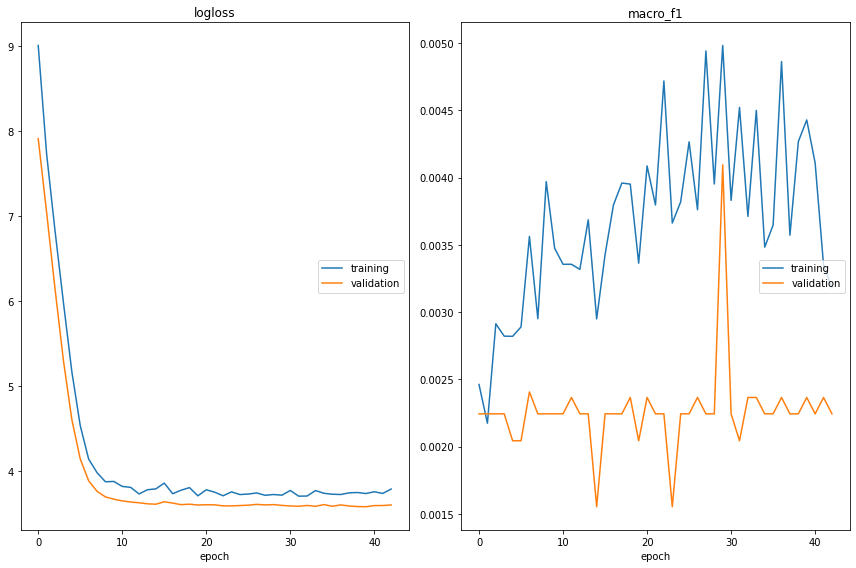

logloss
	training         	 (min:    3.701, max:    9.008, cur:    3.785)
	validation       	 (min:    3.577, max:    7.911, cur:    3.597)
macro_f1
	training         	 (min:    0.002, max:    0.005, cur:    0.003)
	validation       	 (min:    0.002, max:    0.004, cur:    0.002)


KeyboardInterrupt: 

In [14]:
from livelossplot import PlotLosses

def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))

def get_f1_score(batch_y, pred):
    pred_argmax = pred.argmax(1).cpu().detach().numpy().reshape(-1)
    batch_y = batch_y.cpu().detach().numpy().reshape(-1)
    return f1_score(batch_y, pred_argmax, average="macro")
    
liveplot = PlotLosses(groups={"logloss": ["train_logloss", "val_logloss"], 
                              "macro_f1": ["train_f1", "val_f1"]})
epoch_n = 100
steps_per_epoch = 10
test_size = test_new.shape[0]

device = torch.device("cuda")
model.to(device)

for epoch_i in range(epoch_n):
    model.train()
    loss_sum = 0
    f1_sum = 0
    batch_n = 0
    for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
        if batch_i > steps_per_epoch:
            break
            
        batch_x = copy_data_to_device(batch_x, device)
        batch_y = copy_data_to_device(batch_y, device)        

        pred = model(batch_x)
        loss = loss_function(pred, batch_y)
        
        model.zero_grad() 
        loss.backward() 
        optimizer.step()
        
        loss_sum += float(loss)
        f1_sum += float(get_f1_score(batch_y, pred))
        batch_n += 1

    model.eval()
    val_loss_sum = 0
    val_f1_sum = 0
    val_batch_n = 0
    with torch.no_grad():
        for batch_i, (batch_x, batch_y) in enumerate(validation_dataloader):
            if batch_i > test_size // BATCH_SIZE:
                break
        batch_x = copy_data_to_device(batch_x, device)
        batch_y = copy_data_to_device(batch_y, device)        

        pred = model(batch_x.long())
        loss = loss_function(pred, batch_y.long())
        
        val_loss_sum += float(loss)
        val_f1_sum += float(get_f1_score(batch_y, pred))
        val_batch_n += 1
    
    liveplot.update({'train_logloss': loss_sum / batch_n, 
                     'val_logloss': val_loss_sum / val_batch_n,
                     'train_f1': f1_sum / batch_n,
                     'val_f1': val_f1_sum / val_batch_n})
    liveplot.draw()